In [7]:
# This is required to run multiple processes on Unity for some reason.
from multiprocessing import set_start_method
try:
    set_start_method('spawn')
except: #Throws if already set
    pass

# Disable CUDA graphs
import os
os.environ['XLA_FLAGS'] = '--xla_gpu_enable_command_buffer='

In [8]:
%matplotlib widget
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jax
from pathlib import Path
from importlib import reload

src = str(Path('../src').resolve())
if src not in sys.path:
    sys.path.append(src)

from train import load_last_state
from data import TAPDataset, TAPDataLoader
from evaluate import *

In [9]:
run_dir = Path("../runs/hybrid_ensemble/flux_064_20240612_181940")
cfg, model, trainer_state, opt_state = load_last_state(run_dir)
cfg['quiet'] = False

# Bandaid for old configs. 
if not isinstance(cfg['features']['target'],list):
    cfg['features']['target'] = [cfg['features']['target']]
    

Loading model state from ../runs/hybrid_ensemble/flux_064_20240612_181940/epoch100


2024-06-13 17:58:30.433872: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [13]:
dataset = TAPDataset(cfg)

Dropping static attributes with 0 variance: ['glc_pc_s03', 'glc_pc_s05', 'glc_pc_s07', 'glc_pc_s08', 'glc_pc_s17', 'glc_pc_s19', 'pnv_pc_s03', 'wet_pc_s05', 'wet_pc_s06', 'wet_pc_s07']
Using cached basin dataset file.


In [14]:
cfg['data_subset'] = 'test'
cfg['num_workers'] = 1
cfg['basin_subset'] = None
dataloader = TAPDataLoader(cfg, dataset)

results = predict(model, dataloader, seed=0, denormalize=True, return_dt=True)

Dataloader using 1 parallel CPU worker(s).
Batch sharding set to 1 gpu(s)


  0%|          | 0/313 [00:27<?, ?it/s]

2024-06-12 20:52:26.756535: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [15]:
reload(evaluate)
from evaluate import get_all_metrics, get_basin_metrics

bulk_metrics = get_all_metrics(results, False)
basin_metrics = get_basin_metrics(results, True)

Basin Metrics
FLUX
num_obs: 54.0000
nBias: 0.1762
RE: 1.1613
rRMSE: 216.0234
KGE: 0.1417
NSE: -0.2984
Agreement: 0.3994




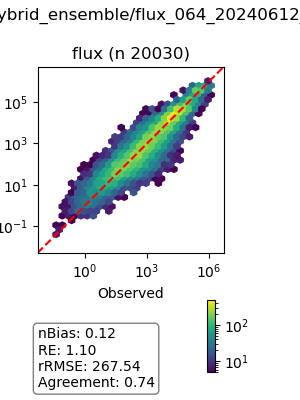

In [16]:
reload(evaluate)
from evaluate import mosaic_scatter

plt.close('all')
fig = mosaic_scatter(cfg, results, bulk_metrics, str(run_dir))

plt.show()
fig.savefig(run_dir / "density_scatter.png",  dpi=300)

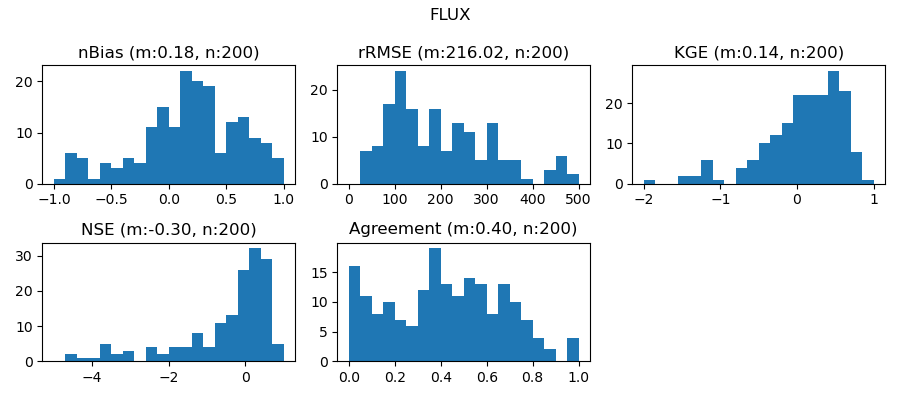

In [17]:
reload(evaluate)
from evaluate import *

metric_args = {
    'nBias':{'range':[-1,1]},
    'rRMSE':{'range':[0,500]},
    'KGE':{'range':[-2,1]},
    'NSE':{'range':[-5,1]},
    'Agreement':{'range':[0,1]}}

plt.close('all')

figs = basin_metric_histograms(basin_metrics, metric_args)

for target, fig in figs.items():
    # fig.show()
    fig.savefig(run_dir / f"{target}_metrics_hist.png",  dpi=300)

In [224]:
basin_metrics

Feature                    ssc                                            \
Metric                   nBias        RE       rRMSE       KGE       NSE   
USGS-01125520         0.269582  0.450479   55.774248  0.415972 -0.791677   
USGS-01127000         0.167913  0.426846   46.484557  0.379381 -0.902758   
USGS-01184000        -0.173457  4.716053  199.045408  0.065591 -17.49544   
USGS-01193050        -1.338441  3.625863   71.428037 -0.386645 -1.278311   
USGS-01198125            0.335  1.008811   84.122735 -1.328536 -0.497919   
...                        ...       ...         ...       ...       ...   
USGS-322023090544500 -0.119357  0.412712   45.385039  0.431045 -0.464703   
USGS-383103106594200       NaN       NaN         NaN       NaN       NaN   
USGS-394220106431500  0.085639  0.955577  161.857343  0.545553 -0.118455   
USGS-402840107004200 -1.194372  0.775201  147.246766  -1.50813  0.151624   
USGS-431510077363501  0.027608  0.837017  138.824403  0.402799 -0.894486   

Feature                        turbidity                                  ...  \
Metric               Agreement     nBias        RE       rRMSE       KGE  ...   
USGS-01125520         0.343859       NaN       NaN         NaN       NaN  ...   
USGS-01127000         0.386459       NaN       NaN         NaN       NaN  ...   
USGS-01184000         0.213423       NaN       NaN         NaN       NaN  ...   
USGS-01193050         0.424125       NaN       NaN         NaN       NaN  ...   
USGS-01198125         0.084846       NaN       NaN         NaN       NaN  ...   
...                        ...       ...       ...         ...       ...  ...   
USGS-322023090544500  0.459171       NaN       NaN         NaN       NaN  ...   
USGS-383103106594200       NaN -0.365531  0.364973   34.154269  0.540887  ...   
USGS-394220106431500  0.699843  0.409059  0.542816  137.521768   0.31603  ...   
USGS-402840107004200  0.302173       NaN       NaN         NaN       NaN  ...   
USGS-431510077363501  0.488299       NaN       NaN         NaN       NaN  ...   

Feature                      flux                                   usgs_q  \
Metric                      rRMSE       KGE        NSE Agreement     nBias   
USGS-01125520                 NaN       NaN        NaN       NaN       NaN   
USGS-01127000                 NaN       NaN        NaN       NaN  0.023235   
USGS-01184000         2374.668121 -0.188188 -96.399529  0.144443  0.036023   
USGS-01193050                 NaN       NaN        NaN       NaN       NaN   
USGS-01198125                 NaN       NaN        NaN       NaN  0.174196   
...                           ...       ...        ...       ...       ...   
USGS-322023090544500    56.100911  0.536932  -0.217988  0.634967       NaN   
USGS-383103106594200          NaN       NaN        NaN       NaN       NaN   
USGS-394220106431500   304.878926  0.366556  -0.903907   0.59203   -0.0049   
USGS-402840107004200   173.798668 -1.020397   0.425729  0.524901       NaN   
USGS-431510077363501          NaN       NaN        NaN       NaN       NaN   

Feature                                                                  
Metric                      RE      rRMSE       KGE       NSE Agreement  
USGS-01125520              NaN        NaN       NaN       NaN       NaN  
USGS-01127000         0.252969  35.844469  0.840891  0.801372  0.915467  
USGS-01184000          0.25988  41.233557  0.864068  0.809882   0.89721  
USGS-01193050              NaN        NaN       NaN       NaN       NaN  
USGS-01198125         0.480159  92.990154  0.550592  0.011063  0.592423  
...                        ...        ...       ...       ...       ...  
USGS-322023090544500       NaN        NaN       NaN       NaN       NaN  
USGS-383103106594200       NaN        NaN       NaN       NaN       NaN  
USGS-394220106431500  0.412236  58.720714  0.915182  0.832845  0.915714  
USGS-402840107004200       NaN        NaN       NaN       NaN       NaN  
USGS-431510077363501       NaN        NaN       NaN   

In [ ]:
from train import Trainer, make_step

cfg['data_subset'] = 'test'
cfg['num_workers'] = 2
cfg['basin_subset'] = None
cfg['log'] = False
cfg['quiet'] = False
dataloader = TAPDataLoader(cfg, dataset)
trainer = Trainer(cfg, dataloader)

step_kwargs = cfg['step_kwargs']
step_kwargs['max_grad_norm'] = None

for basin, date, batch in dataloader:
    break

key = jax.random.PRNGKey(0)
batch_keys = jax.random.split(key, len(basin))

loss, grads, model, opt_state = make_step(
    model, 
    batch,
    batch_keys,
    opt_state, 
    trainer.optim, 
    trainer.filter_spec, 
    **step_kwargs
    )

In [ ]:
batch['x_s']

In [ ]:
embedded = jax.vmap(model.static_embedder)(batch['x_s'], batch_keys)
# jax.vmap(grads.static_embedder.linear)(embedded).shape
plt.close('all')
plt.imshow(embedded[0,...])

In [ ]:
import umap

static_embeddings = model.static_embedder.linear.weight
# static_embeddings = grads.static_embedder.linear.weight

# Suppose `static_embeddings` is an array containing your static embeddings
reducer = umap.UMAP(n_neighbors=64, n_components=2, metric='euclidean')
embedding_2d = reducer.fit_transform(static_embeddings)

In [ ]:
# Plot using matplotlib
plt.close('all')
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c='blue', alpha=0.5)
plt.title('2D UMAP Projection of Static Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
# plt.colorbar(label='Cluster label')  # Optional: if you have cluster labels
plt.show()

In [ ]:
static_sums = np.sum(np.abs(static_embeddings),axis=0)
sorted_ids = np.argsort(-static_sums)

static_features = list(dataset.attributes_scale.keys())
for i in range(25):
    idx = sorted_ids[i]
    print(f"{static_features[idx]}: {static_sums[idx]}")

In [ ]:
plt.figure()
plt.hist(static_sums)

In [ ]:
plt.close('all')
plt.imshow(static_embeddings, aspect='auto')
plt.show()

In [ ]:
model.decoder.layers[0].attention_block.attention

In [ ]:
plt.close('all')

fig, ax = plt.subplots(figsize=(6,6))

x = results['obs']
y = results['pred']
z = []

dt_max = 10
for dt in range(dt_max+1):
    if dt < dt_max:
        mask = np.abs(results['dt']) == dt
    else:
        mask = np.abs(results['dt']) >= dt
    metrics = get_all_metrics(x[mask], y[mask])
    z.append(metrics['lNSE'])

ax.plot(z)

xticks = range(0,dt_max+1,2)
xtick_labels = ax.get_xticklabels()
new_labels = ["≥" + str(int(tick)) if tick == dt_max else str(int(tick)) for tick in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(new_labels)

plt.show()

In [ ]:
import evaluate
reload(evaluate)
from evaluate import predict, get_all_metrics

basin = np.random.choice(dataset.basins).tolist()
# basin = 'USGS-09367540'
# basin = 'USGS-06109500' #no flux but nice seasonality
basin = 'USGS-08332010' #Nice flux temporal distribution and seasonality

cfg['data_subset'] = 'predict'
cfg['basin_subset'] =  basin
cfg['num_workers'] = 0 # Faster for small runs
dataloader = TAPDataLoader(cfg, dataset)

results, metrics = predict(model, dataloader, seed=0, denormalize=True, return_dt=True)
results['pred'] = results['pred'] * (results['pred']>0) #Clip predictions to 0

results = results.reset_index()
results = results.sort_values(by='date')
results = results.drop(columns=['basin'])
results.set_index('date', inplace=True)

In [ ]:
import matplotlib.gridspec as gridspec
# Plot the true values and predictions
plt.close('all')


# Create a figure
fig = plt.figure(figsize=(10, 4))

# Create a GridSpec with 1 row and 3 columns
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 0.2, 2])
axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 2])]

pred = results['pred']
obs = results['obs']



min_val = 1E-1
max_val = 5E5
axes[0].scatter(obs, pred)
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--')

# Setting axes to be square and equal range
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].axis('square')
axes[0].set_xlim(min_val, max_val)
axes[0].set_ylim(min_val, max_val)
axes[0].set_xlabel(f"Observed {cfg['features']['target']}")
axes[0].set_ylabel(f"Predicted {cfg['features']['target']}")

axes[0].set_title(f"Basin: {basin}")


pred.plot(ax=axes[1])
obs.plot(ax=axes[1], linestyle='None',marker='.')
axes[1].set_ylim([0,40000])

textstr = '\n'.join([f"{key}: {metrics[key]:0.2f}" for key in ['nBias', 'rRMSE', 'lNSE', 'Agreement']])
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
axes[1].text(0.02, 0.97, textstr, transform=axes[1].transAxes, fontsize=10,
        va='top', ha='left', bbox=props)


fig.subplots_adjust(top=0.85, left=0.05, right=0.95, wspace=0.05, hspace=0.4)
fig.suptitle(str(run_dir))
fig.autofmt_xdate()

plt.show()

fig.savefig(run_dir / f"{basin}_timeseries.png",  dpi=300)